# Interacting with Articulated Agents (Habitat-Lab 레벨 Tutorial)
출처: third_party/habitat-lab/examples/tutorials/articulated_agents_tutorial.ipynb

# 주의: data 경로 설정 필요!!!
Set up a symbolic link to your Habitat data directory in habitat_llm/data

- Agent Initialization 방법 (어떤 robot? 어떤 sensor 부착?)
- Scene 탐방 방법
- Dynamic vs Kinematic simulation
- Object Interaction 방법
- Action Interaction 방법

### 1. Agent initialization

In [1]:
import habitat_sim
import magnum as mn
import warnings
from habitat.tasks.rearrange.rearrange_sim import RearrangeSim
warnings.filterwarnings('ignore')
from habitat_sim.utils.settings import make_cfg
from matplotlib import pyplot as plt
from habitat_sim.utils import viz_utils as vut
from omegaconf import DictConfig
import numpy as np
from habitat.articulated_agents.robots import FetchRobot
from habitat.config.default import get_agent_config
import habitat
from habitat_sim.physics import JointMotorSettings, MotionType
from omegaconf import OmegaConf

import git, os
repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "data")
os.chdir(dir_path)

# Initializing a scene with agents
Set Simulator(ex. RearrangeSim) Config -> Set Agent Config -> Create the Scene -> Initialize Sim -> InitializeAgent

In the first part of this tutorial we will use `RearrangeSim` as our simulator, which is an abstraction over [HabitatSimulator](https://aihabitat.org/docs/habitat-lab/habitat.core.simulator.Simulator.html) and includes functionalities to update agent cameras and position or interact with objects. In the second part of the tutorial, we will be defining agent actions and will be using a `RearrangeEnvironment`, which contains a reference to the simulator, as well as functions to define and execute agent actions, obtain rewards or termination conditions. The RearrangeEnvironment will also be used to train agents via RL.


## Defining agent configurations
We start by defining a configuration for each agent we want to add. Articulated agents are represented as any other articulated object, and are therefore defined via an URDF file. While this file is enough to represent the agent as an object, it doesn't include a way to easily set its base position, reset its joints, move a specific part or query other attributes.

To simplify this, we provide an abstraction, `ArticulatedAgent`, which will wrap habitat-sim's ManagedArticulatedObject class initialized from the URDF and provide functionalities that are commonly useful for agent control. You can view the different ArticulatedAgents (robots and humanoids) [here](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-lab/habitat/articulated_agents).

Config로 Agent를 설정해줍시다. 중요한 Sensors는 아래 방법처럼 넣을 수 있습니다.  
이외에도 default_structured_configs에 있는 다른 설정들 참고하면 이해가 될 것 같습니다.  
URDF는 Unified Robot Description Format를 의미합니다. -> 원하는 robot을 알맞은 .urdf를 넣어줌으로써 설정할 수 있습니다.

In [2]:
from habitat.config.default_structured_configs import ThirdRGBSensorConfig, HeadRGBSensorConfig, HeadPanopticSensorConfig
from habitat.config.default_structured_configs import SimulatorConfig, HabitatSimV0Config, AgentConfig

# Agent config 정의
main_agent_config = AgentConfig()

urdf_path = os.path.join(data_path, "robots/hab_fetch/robots/hab_fetch.urdf")
main_agent_config.articulated_agent_urdf = urdf_path
main_agent_config.articulated_agent_type = "FetchRobot"

# Agent Config 속 Sensor 정의
main_agent_config.sim_sensors = {
    "third_rgb": ThirdRGBSensorConfig(),
    "head_rgb": HeadRGBSensorConfig(),
}

# dictionary로 agent_dict 만들기
# agent_1, agent_2 이런 식으로 하는 것으로 보임
agent_dict = {"main_agent": main_agent_config}

SimulatorConfig 만들기 -> 해당 Config에 dataset들 (scene과 additional_object 등등) 넣어주고, OmegaConf로 만들기

In [3]:
sim_cfg = SimulatorConfig(type="RearrangeSim-v0")

# This is for better graphics
sim_cfg.habitat_sim_v0.enable_hbao = True
sim_cfg.habitat_sim_v0.enable_physics = True

# Set up an example scene
# hssd-hab dataset 사용
sim_cfg.scene = os.path.join(data_path, "hssd-hab/scenes-partnr-filtered/102344022.scene_instance.json") # 진짜 그 scene을 정의하는 json
sim_cfg.scene_dataset = os.path.join(data_path, "hssd-hab/hssd-hab-partnr.scene_dataset_config.json") # 이외에 scene load에 필요한 데이터셋들 경로 저장
sim_cfg.additional_object_paths = [os.path.join(data_path, 'objects/ycb/configs/')] # 추가 objects 경로

# main scene config를 cfg로 만들기
cfg = OmegaConf.create(sim_cfg)

자 이제 SimConfig에 Agent를 넣어주고, Sim을 만들어 줍시다..   
밑의 예시는 아까 방법 말고, 새로운 방법으로 카메라 추가하는 방법으로 보임. (아직 정확하게 모름)

In [4]:
# main scene config에 agent_dict 넣기
cfg.agents = agent_dict
cfg.agents_order = list(cfg.agents.keys())

# Sim 만들기
sim = RearrangeSim(cfg)

# Agent Initialization 시키기
sim.agents_mgr.on_new_scene()

# 아까 단 카메라 외에 다른 방법으로 카메라를 추가할 수도 있음
# 예시에선 scene_camera_rgb
camera_sensor_spec = habitat_sim.CameraSensorSpec()
camera_sensor_spec.sensor_type = habitat_sim.SensorType.COLOR
camera_sensor_spec.uuid = "scene_camera_rgb"

# TODO: this is a bit dirty but I think its nice as it shows how to modify a camera sensor...
sim.add_sensor(camera_sensor_spec, 0)

: 

이제 Sim에서 Scene이 만들어졌으니, Agent의 정보를 Sim에 요청하고, setting도 가능합니다.

In [6]:
init_pos = mn.Vector3(-5.5,0,-1.5)
art_agent = sim.articulated_agent

# 어떤 모션을 쓸 것인지?
art_agent.sim_obj.motion_type = MotionType.KINEMATIC

# base_pos를 설정해줍니다.
print("Current agent position:", art_agent.base_pos)
art_agent.base_pos = init_pos 
print("New agent position:", art_agent.base_pos)

# update를 위해선 sim.step을 사용해줍니다. (이런 식으로 config를 바꿔주고, 그 바뀐 config를 사용해서 다음 step을 만들어줘야 할 것 같습니다.)
_ = sim.step({})

Current agent position: Vector(0, 0, 0)
New agent position: Vector(-5.5, 0, -1.5)


이 정보를 관측해봅시다. sim.get_sensor_observations()  
처음에 단 third_rgb, head_rgb 외에 scene_camera_rgb도 추가되어 있는 것 확인 가능.  
이렇게 sim.get_sensor_observations()를 통해, sensor로 들어오는 정보를 관측할 수 있습니다. (직접적인 observation value는 아직 잘 모르겠습니다)

In [7]:
observations = sim.get_sensor_observations()
print(observations.keys())

dict_keys(['third_rgb', 'head_rgb', 'scene_camera_rgb'])


plot 해서 살펴보기

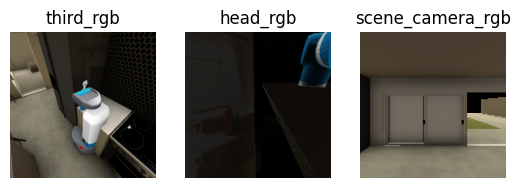

In [8]:
_, ax = plt.subplots(1,len(observations.keys()))

for ind, name in enumerate(observations.keys()):
    ax[ind].imshow(observations[name])
    ax[ind].set_axis_off()
    ax[ind].set_title(name)

앞서 정의한 agent에 달려있는 cameras가 어디 있는지 보려면 아래 처럼 하면 된다고 합니다.

In [9]:
art_agent.params.cameras.keys()

dict_keys(['articulated_agent_arm', 'head', 'third'])

Whenever a sensor name starts with any of these names, it will be set to have the behavior specified in the agent_params. You can look at the ArticulatedAgent definition to see the different specified cameras.

# Moving an agent around the scene
The next step is to move the agent and its parts around the scene. Let's start by translating and rotating the agent base. We will be recording each frame and generating a video.

## Moving the agent base

앞서 했던 방법 처럼, pos 설정 -> sim.step()의 반복을 통해 움직이는 것으로 보임  
아래 영상은 벽을 뚫는데, 아마 partnr의 예시에선 collisonSensor를 통해 trained되어 벽을 뚫지 않나 싶네요.  
sim.reset()은 뭔지 모르겠는데, 이걸 주석처리 해야 돌아갑니다.

In [14]:
observations = []
num_iter = 100
pos_delta = mn.Vector3(0.02,0,0)
rot_delta = np.pi / (8 * num_iter)
art_agent.base_pos = init_pos

# sim.reset()
# set_fixed_camera(sim)
for _ in range(num_iter):
    # TODO: this actually seems to give issues...
    art_agent.base_pos = art_agent.base_pos + pos_delta
    art_agent.base_rot = art_agent.base_rot + rot_delta
    sim.step({})
    observations.append(sim.get_sensor_observations())

vut.make_video(
    observations,
    "scene_camera_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)
vut.make_video(
    observations,
    "third_rgb",
    "color",
    "robot_tutorial_video",
    open_vid=True,
)

Encoding the video: robot_tutorial_video.mp4 


Encoding the video: robot_tutorial_video.mp4 


앞서 우리가 agent를 이동시켰기 때문에, agent 가리키는 카메라는 같이 따라가고, 나중에 설치한 scene_camera는 고정